<center>

#  **KLASIFIKASI TOPIK DAN SENTIMEN ULASAN VIDEO YOUTUBE TENTANG BENCANA BANJIR BANDANG SUMATERA**  
## **MENGGUNAKAN ALGORITMA SUPPORT VECTOR MACHINE (Studi Kasus Channel Najwa Shihab)**

---

### **Project Akhir Pemrosesan Bahasa Alami**
**Oleh: _Kelompok 3_**  
**Universitas Amikom Purwokerto**

**1 Desember - 21 Desember 2025**

</center>


# **Pengumpulan Data Komentar**

In [ ]:
#@title Install Google API Client

%pip install google-api-python-client

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Set Google API Key

def_api_key = "YOUR_API_KEY_HERE" 

In [27]:
#@title Import Libraries

from googleapiclient.discovery import build
import pandas as pd
import time

In [28]:
#@title Inisialisasi YouTube API Client

# Ganti dengan Channel ID (bukan username)
channel_id = 'UCo8h2TY_uBkAVUIc14m_KCA'

# Inisialisasi client
youtube = build('youtube', 'v3', developerKey=def_api_key)

def get_uploads_playlist_id(channel_id):
    response = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()

    if 'items' not in response or not response['items']:
        print("Channel tidak ditemukan.")
        return None

    uploads_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    return uploads_id

# Jalankan
uploads_playlist_id = get_uploads_playlist_id(channel_id)
print(f"Playlist uploads ID: {uploads_playlist_id}")

Playlist uploads ID: UUo8h2TY_uBkAVUIc14m_KCA


In [29]:
#@title Inisialisasi Playlist Tersembunyi

# Playlist tersembunyi
def_playlist_id = uploads_playlist_id

In [30]:
#@title Ambil Semua Video dari Playlist Tersembunyi

# Inisialisasi client
youtube = build('youtube', 'v3', developerKey=def_api_key)

def get_videos_from_playlist(playlist_id):
    video_ids = []
    next_page_token = None

    while True:
        res = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()

        for item in res['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = res.get('nextPageToken')
        if not next_page_token:
            break
        time.sleep(0.1)

    return video_ids

def get_video_details(video_ids):
    video_data = []

    for i in range(0, len(video_ids), 50):
        batch_ids = video_ids[i:i+50]
        res = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(batch_ids)
        ).execute()

        for item in res['items']:
            data = {
                'videoId': item['id'],
                'title': item['snippet']['title'],
                'publishedAt': item['snippet']['publishedAt'],
                'viewCount': int(item['statistics'].get('viewCount', 0)),
                'commentCount': int(item['statistics'].get('commentCount', 0))
            }
            video_data.append(data)

    return video_data

# Ambil semua video ID dari playlist
video_ids = get_videos_from_playlist(def_playlist_id)

# Ambil detail dari video-video tersebut
video_details = get_video_details(video_ids)

# Simpan ke DataFrame
df_raw = pd.DataFrame(video_details)

# Tampilkan 5 baris pertama
print(df_raw.head())

# Simpan ke file CSV (opsional)
df_raw.to_csv("video_playlist.csv", index=False)

       videoId                                              title  \
0  o_kPRkMGYZw                 Hidupkan Aceh Tamiang | Mata Najwa   
1  7sDvB_8l5pw  Presiden Prabowo dan Pekerjaan Pascabanjir | M...   
2  NwDZOr0z58o  Korban Banjir Aceh: Anak Hilang Hanyut di Depa...   
3  hiP76ZBZnw4  Gubernur Aceh Bicara: Status Bencana, Kepala D...   
4  LTZdQSVIzVg  Potret Dampak Banjir Sumut: Di Antara Puing, W...   

            publishedAt  viewCount  commentCount  
0  2025-12-11T14:28:05Z     107874           196  
1  2025-12-10T14:15:26Z     181076           267  
2  2025-12-08T14:09:25Z     384173           837  
3  2025-12-08T14:05:20Z    2461238         13097  
4  2025-12-02T09:24:20Z     775168           980  


Setelah memasukkan data video ke data frame dan menghasilkan file "video_playlist.csv" langkah selanjutnya adalah buka file tersebut dan edit isi file tersebut dengan menghapus data video yang tidak akan di scraping. setelah itu simpan dan jalankan tahap berikutnnya.



In [31]:
#@title Ambil Komentar dari Video

youtube = build('youtube', 'v3', developerKey=def_api_key)

# id pemillik
def_id_pemilik = "@NajwaShihab"
# tentukan jumlah video teratas
def_jumlah_video = 7

# Baca CSV video_playlist.csv
df_videos = pd.read_csv('video_playlist.csv')

# Urutkan berdasarkan commentCount descending dan ambil video teratas
df_videos_sorted = df_videos.sort_values(by='commentCount;', ascending=False).head(def_jumlah_video)

# Buat dict videoId ke title dari data yang sudah disortir
video_title_map = dict(zip(df_videos_sorted['videoId'], df_videos_sorted['title']))

# Ambil videoId list yang sudah disortir dan dibatasi
video_ids = df_videos_sorted['videoId'].tolist()

def get_comments(video_id):
    comments = []
    request = youtube.commentThreads().list(
        part='snippet,replies',
        videoId=video_id,
        maxResults=1000,
        textFormat='plainText'
    )

    while request:
        response = request.execute()
        for item in response['items']:
            top_comment = item['snippet']['topLevelComment']['snippet']
            if (top_comment['authorDisplayName'] == def_id_pemilik and def_id_pemilik != ''):
                continue
            comments.append({
                'author': top_comment['authorDisplayName'],
                'comment': top_comment['textDisplay'],
                'likeCount': top_comment['likeCount'],
                'isReply': False
            })

            if 'replies' in item:
                for reply in item['replies']['comments']:
                    reply_snippet = reply['snippet']
                    if (reply_snippet['authorDisplayName'] == def_id_pemilik and def_id_pemilik != ''):
                        continue
                    comments.append({
                        'author': reply_snippet['authorDisplayName'],
                        'comment': reply_snippet['textDisplay'],
                        'likeCount': reply_snippet['likeCount'],
                        'isReply': True
                    })

        request = youtube.commentThreads().list_next(request, response)
        time.sleep(0.1)

    return comments

def get_video_title(video_id):
    return video_title_map.get(video_id, 'Unknown Title')

all_comment_data = []

batch_size = 10
for i in range(0, len(video_ids), batch_size):
    batch = video_ids[i:i+batch_size]
    print(f"Processing batch videos {i+1} to {i+len(batch)}")

    for video_id in batch:
        print(f"  Mengambil komentar video {video_id}")
        title = get_video_title(video_id)
        comments = get_comments(video_id)

        for c in comments:
            all_comment_data.append({
                'videoId': video_id,
                'title': title,
                'author': c['author'],
                'comment': c['comment'],
                'likeCount': c['likeCount'],
                'isReply': c['isReply']
            })

    time.sleep(10)

df_raw = pd.DataFrame(all_comment_data)
print(df_raw.head())
df_raw.to_csv('hasil_scraping.csv', index=False)

Processing batch videos 1 to 7
  Mengambil komentar video LTZdQSVIzVg
  Mengambil komentar video NwDZOr0z58o
  Mengambil komentar video U9BcphwOHUg
  Mengambil komentar video 7sDvB_8l5pw
  Mengambil komentar video ouR11bOMzVM
  Mengambil komentar video o_kPRkMGYZw
  Mengambil komentar video hiP76ZBZnw4
       videoId                                              title  \
0  LTZdQSVIzVg  Potret Dampak Banjir Sumut Di Antara Puing War...   
1  LTZdQSVIzVg  Potret Dampak Banjir Sumut Di Antara Puing War...   
2  LTZdQSVIzVg  Potret Dampak Banjir Sumut Di Antara Puing War...   
3  LTZdQSVIzVg  Potret Dampak Banjir Sumut Di Antara Puing War...   
4  LTZdQSVIzVg  Potret Dampak Banjir Sumut Di Antara Puing War...   

              author                                            comment  \
0         @Fakhira45                         Mulia kerja mu najwa.. 🤲👍❤   
1  @dekirizalman6886                 CIE GAK BERANI KRITIK PEMERINTAH 😂   
2     @YouTubeZholim                              Polri 

# **Pemuatan Dataset dan Pembersihan Data**

In [5]:
#@title Membaca Dataset Hasil Scraping

import pandas as pd

file_path = "hasil_scraping.csv"
df_raw = pd.read_csv(file_path)

#Cek Struktur Dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15983 entries, 0 to 15982
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   videoId    15983 non-null  object
 1   title      15983 non-null  object
 2   author     15983 non-null  object
 3   comment    15982 non-null  object
 4   likeCount  15983 non-null  int64 
 5   isReply    15983 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 640.1+ KB


In [6]:
#@title Tampilkan 10 Baris Pertama Dataset

df_raw.head(10)

,videoId,title,author,comment,likeCount,isReply
0,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@Fakhira45,Mulia kerja mu najwa.. 🤲👍❤,0,False
1,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@dekirizalman6886,CIE GAK BERANI KRITIK PEMERINTAH 😂,0,False
2,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@YouTubeZholim,Polri TDK pnya empati,0,False
3,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@RomeoTuwek-i9k,Moga bersabar ya saudaraku dri Indonesia kami ...,0,False
4,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@fashaSyarif,Sayangi anak2 kami y kelaparan dan takut wabah...,0,False
5,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@fashaSyarif,Mbak Najwa tolong komunikasi sama pak prabowo ...,0,False
6,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@DedeRiyandi-x6w,2029 jabatan menteri apa yang pantas di pegan...,0,False
7,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@anakrantaumsc2243,Ibuk yang pertama di temuin mbak najwa mirip i...,0,False
8,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@MusaLina-z5g,Hebat.\nSila rujuk meteoroloji. Akan ada taufa...,0,False
9,LTZdQSVIzVg,Potret Dampak Banjir Sumut Di Antara Puing War...,@nisyasundari5343,mereka masih bisa tersenyum dgn keadaan yg beg...,0,False


In [7]:
#@title Ambil Hanya Kolom Comment
df_cleaned = df_raw[["comment"]].copy()

print(df_cleaned.head())
print("\nJumlah total komentar (sebelum filtering):", len(df_cleaned))

                                             comment
0                         Mulia kerja mu najwa.. 🤲👍❤
1                 CIE GAK BERANI KRITIK PEMERINTAH 😂
2                              Polri TDK pnya empati
3  Moga bersabar ya saudaraku dri Indonesia kami ...
4  Sayangi anak2 kami y kelaparan dan takut wabah...

Jumlah total komentar (sebelum filtering): 15983


In [8]:
#@title Cek Struktur Data
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15983 entries, 0 to 15982
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  15982 non-null  object
dtypes: object(1)
memory usage: 125.0+ KB


In [9]:
#@title Preprocessing Awal: Hapus Nilai Null dan Duplikat

df_preprocessed = (
    df_cleaned
    .dropna(subset=["comment"])
    .drop_duplicates(subset=["comment"], keep="first")
    .reset_index(drop=True)
)

print("\nSETELAH PREPROCESSING AWAL:")
df_preprocessed.info()


SETELAH PREPROCESSING AWAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15354 entries, 0 to 15353
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  15354 non-null  object
dtypes: object(1)
memory usage: 120.1+ KB


# **Wordcloud dan Frekuensi Kata Sebelum Preprocessing**

Note: you may need to restart the kernel to use updated packages.


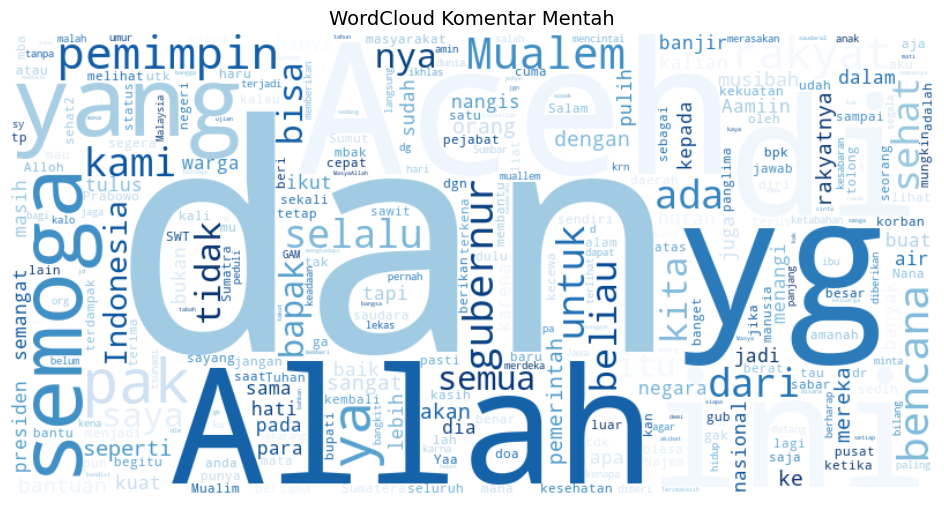

In [10]:
#@title Visualisasi WordCloud Komentar Mentah

%pip install matplotlib wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Pastikan tidak ada NaN
df_preprocessed['comment'] = df_preprocessed['comment'].fillna('')

# Gabungkan seluruh komentar mentah
text_raw = " ".join(df_preprocessed['comment'].astype(str))

# Stopwords tambahan (opsional)
stopwords = set(STOPWORDS)
stopwords.update([
    'https'
])

# Generate WordCloud
wc = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    width=800,
    height=400,
    collocations=False,
    colormap='Blues'
).generate(text_raw)

# Tampilkan WordCloud
plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Komentar Mentah", fontsize=14)
plt.show()

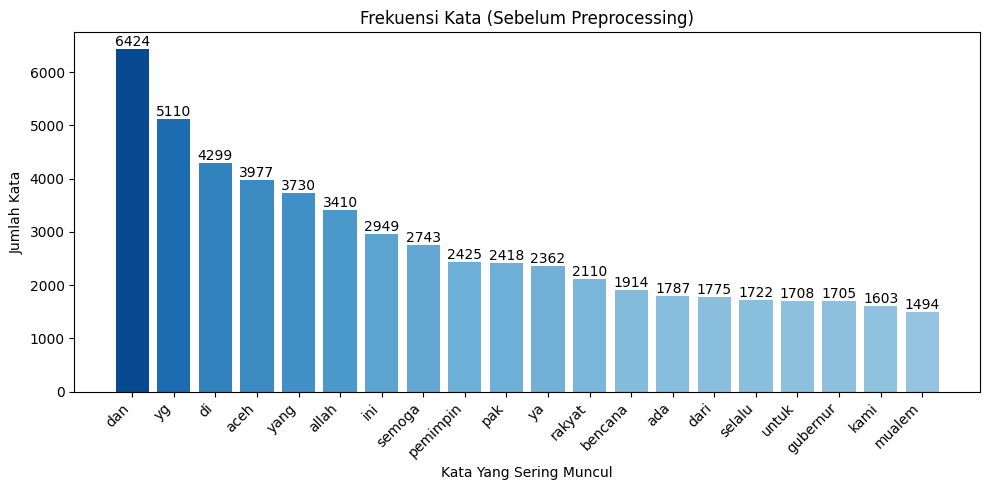

In [11]:
#@title Visualisasi Frekuensi Kata Komentar Mentah

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Gabungkan semua komentar
text_raw = " ".join(df_preprocessed['comment'].astype(str))

# Tokenisasi sederhana
tokens = text_raw.lower().split()

# Hitung frekuensi
word_freq = Counter(tokens)

# DataFrame Top 10
df_freq = pd.DataFrame(
    word_freq.items(),
    columns=['kata', 'frekuensi']
).sort_values(by='frekuensi', ascending=False).head(20)

# Bar Chart Dinamis
plt.figure(figsize=(10,5))

# Normalisasi frekuensi (0–1)
counts = df_freq['frekuensi'].values
norm = (counts - counts.min()) / (counts.max() - counts.min() + 1e-6)

# Mapping warna: biru soft → biru jelas
colors = plt.cm.Blues(0.4 + 0.5 * norm)
# 0.4 = soft, 0.9 = jelas

bars = plt.bar(df_freq['kata'], df_freq['frekuensi'], color=colors)

plt.xlabel("Kata Yang Sering Muncul")
plt.ylabel("Jumlah Kata")
plt.title("Frekuensi Kata (Sebelum Preprocessing)")
plt.xticks(rotation=45, ha='right')

# Angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# **Preprocessing Teks**

In [12]:
#@title Case Folding: Ubah Teks Menjadi Huruf Kecil

def to_lowercase(text):
    return text.lower() if isinstance(text, str) else text

df_preprocessed = df_preprocessed[df_preprocessed['comment'].notna()]
df_preprocessed = df_preprocessed[df_preprocessed['comment'].str.strip() != ""]
df_preprocessed['casefold'] = df_preprocessed['comment'].apply(to_lowercase)

print("Setelah Case Folding:")
display(df_preprocessed.head())


Setelah Case Folding:


,comment,casefold
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂
2,Polri TDK pnya empati,polri tdk pnya empati
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...


In [13]:
#@title Cleaning: Hapus Username, Emoji, Simbol, Angka, dan Rapikan Spasi

import re
import string

# Fungsi Cleaning

# Hapus username (@user)
def remove_username(text):
    if isinstance(text, str):
        return re.sub(r'@\S+', '', text)
    return text

# Hapus emoji
def remove_emoji(text):
    if isinstance(text, str):
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"
            u"\U0001F780-\U0001F7FF"
            u"\U0001F800-\U0001F8FF"
            u"\U0001F900-\U0001F9FF"
            u"\U0001FA00-\U0001FAFF"
            u"\U0001F1E0-\U0001F1FF"  # flags
            "]+", flags=re.UNICODE
        )
        return emoji_pattern.sub('', text)
    return text

# Hapus simbol & tanda baca
def remove_symbols(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-z\s]', ' ', text)
        return text
    return text

# Hapus angka
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text

# Rapikan spasi
def normalize_whitespace(text):
    if isinstance(text, str):
        return re.sub(r'\s+', ' ', text).strip()
    return text


# Terapkan Cleaning

df_preprocessed['clean'] = df_preprocessed['casefold'].apply(remove_username)
df_preprocessed['clean'] = df_preprocessed['clean'].apply(remove_emoji)
df_preprocessed['clean'] = df_preprocessed['clean'].apply(remove_symbols)
df_preprocessed['clean'] = df_preprocessed['clean'].apply(remove_numbers)
df_preprocessed['clean'] = df_preprocessed['clean'].apply(normalize_whitespace)

# Cek Hasil
print("Setelah Cleaning & Emoji Removal:")
display(df_preprocessed.head())


Setelah Cleaning & Emoji Removal:


,comment,casefold,clean
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂,cie gak berani kritik pemerintah
2,Polri TDK pnya empati,polri tdk pnya empati,polri tdk pnya empati
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak kami y kelaparan dan takut wabah ...


In [14]:
#@title Import Libraries for Text Preprocessing

import pandas as pd
import re

In [15]:
#@title Normalization: Slang / Kata Tidak Baku

def normalize_slang_advanced(text, kamus_tidak_baku):
    if not isinstance(text, str):
        return text

    words = text.split()
    normalized_words = []

    for word in words:
        if word in kamus_tidak_baku:
            normalized_words.append(kamus_tidak_baku[word])
        else:
            normalized_words.append(word)

    return " ".join(normalized_words)


In [16]:
#@title Load Kamus Kata Tidak Baku

import pandas as pd

kamus_data = pd.read_excel('kamuskatabaku.xlsx')

# Lowercase agar cocok dengan case folding
kamus_data['tidak_baku'] = kamus_data['tidak_baku'].str.lower()
kamus_data['kata_baku'] = kamus_data['kata_baku'].str.lower()

kamus_tidak_baku = dict(
    zip(kamus_data['tidak_baku'], kamus_data['kata_baku'])
)

kamus_data.head()


,tidak_baku,kata_baku
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


In [17]:
#@title Normalization: Slang / Kata Tidak Baku

df_preprocessed['slang'] = df_preprocessed['clean'].apply(
    lambda x: normalize_slang_advanced(x, kamus_tidak_baku)
)

print("Setelah Normalisasi Slang:")
display(df_preprocessed.head())


Setelah Normalisasi Slang:


,comment,casefold,clean,slang
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa,mulia kerja mu najwa
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂,cie gak berani kritik pemerintah,cie tidak berani kritik pemerintah
2,Polri TDK pnya empati,polri tdk pnya empati,polri tdk pnya empati,polri tidak punya empati
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dari indonesia kami...
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak kami y kelaparan dan takut wabah ...,sayangi anak kami ya kelaparan dan takut wabah...


In [18]:
#@title Tokenization: Memecah Teks Menjadi Token

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return []

# Terapkan ke kolom slang
df_preprocessed['tokenizing'] = df_preprocessed['slang'].apply(tokenize_text)

print("Setelah tokenizing:")
display(df_preprocessed.head())

[nltk_data] Downloading package punkt to C:\Users\Hardika
[nltk_data]     Setiyawan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Hardika
[nltk_data]     Setiyawan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Setelah tokenizing:


,comment,casefold,clean,slang,tokenizing
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa,mulia kerja mu najwa,"[mulia, kerja, mu, najwa]"
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂,cie gak berani kritik pemerintah,cie tidak berani kritik pemerintah,"[cie, tidak, berani, kritik, pemerintah]"
2,Polri TDK pnya empati,polri tdk pnya empati,polri tdk pnya empati,polri tidak punya empati,"[polri, tidak, punya, empati]"
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dari indonesia kami...,"[moga, bersabar, ya, saudaraku, dari, indonesi..."
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak kami y kelaparan dan takut wabah ...,sayangi anak kami ya kelaparan dan takut wabah...,"[sayangi, anak, kami, ya, kelaparan, dan, taku..."


In [19]:
#@title Stopword Removal

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Pertahankan kata negasi
negation_words = {"tidak", "bukan", "jangan", "tak"}
stop_words = stop_words - negation_words

def remove_stopwords_tokens(tokens):
    if not isinstance(tokens, list):
        return []
    return [word for word in tokens if word.lower() not in stop_words]

# Terapkan
df_preprocessed['stopword'] = df_preprocessed['tokenizing'].apply(remove_stopwords_tokens)

print("Setelah Stopword Removal:")
display(df_preprocessed.head())


Setelah Stopword Removal:


[nltk_data] Downloading package stopwords to C:\Users\Hardika
[nltk_data]     Setiyawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comment,casefold,clean,slang,tokenizing,stopword
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa,mulia kerja mu najwa,"[mulia, kerja, mu, najwa]","[mulia, kerja, mu, najwa]"
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂,cie gak berani kritik pemerintah,cie tidak berani kritik pemerintah,"[cie, tidak, berani, kritik, pemerintah]","[cie, tidak, berani, kritik, pemerintah]"
2,Polri TDK pnya empati,polri tdk pnya empati,polri tdk pnya empati,polri tidak punya empati,"[polri, tidak, punya, empati]","[polri, tidak, empati]"
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dari indonesia kami...,"[moga, bersabar, ya, saudaraku, dari, indonesi...","[moga, bersabar, ya, saudaraku, indonesia, mal..."
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak kami y kelaparan dan takut wabah ...,sayangi anak kami ya kelaparan dan takut wabah...,"[sayangi, anak, kami, ya, kelaparan, dan, taku...","[sayangi, anak, ya, kelaparan, takut, wabah, p..."


In [20]:
#@title Stemming

# Install library (sekali saja)
%pip install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming
def stem_tokens(tokens):
    if not isinstance(tokens, list):
        return []
    stemmed_words = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed_words)

# Terapkan stemming
df_preprocessed['stemmed'] = df_preprocessed['stopword'].apply(stem_tokens)

print("Setelah Stemming:")
display(df_preprocessed.head())


Note: you may need to restart the kernel to use updated packages.
Setelah Stemming:


,comment,casefold,clean,slang,tokenizing,stopword,stemmed
0,Mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa.. 🤲👍❤,mulia kerja mu najwa,mulia kerja mu najwa,"[mulia, kerja, mu, najwa]","[mulia, kerja, mu, najwa]",mulia kerja mu najwa
1,CIE GAK BERANI KRITIK PEMERINTAH 😂,cie gak berani kritik pemerintah 😂,cie gak berani kritik pemerintah,cie tidak berani kritik pemerintah,"[cie, tidak, berani, kritik, pemerintah]","[cie, tidak, berani, kritik, pemerintah]",cie tidak berani kritik perintah
2,Polri TDK pnya empati,polri tdk pnya empati,polri tdk pnya empati,polri tidak punya empati,"[polri, tidak, punya, empati]","[polri, tidak, empati]",polri tidak empati
3,Moga bersabar ya saudaraku dri Indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dri indonesia kami ...,moga bersabar ya saudaraku dari indonesia kami...,"[moga, bersabar, ya, saudaraku, dari, indonesi...","[moga, bersabar, ya, saudaraku, indonesia, mal...",moga sabar ya saudara indonesia malaysia senti...
4,Sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak2 kami y kelaparan dan takut wabah...,sayangi anak kami y kelaparan dan takut wabah ...,sayangi anak kami ya kelaparan dan takut wabah...,"[sayangi, anak, kami, ya, kelaparan, dan, taku...","[sayangi, anak, ya, kelaparan, takut, wabah, p...",sayang anak ya lapar takut wabah sakit landa


In [21]:
#@title Final Preprocessing: Hapus Duplikat, Data Kosong, dan Komentar Pendek

# Hapus duplikat & data kosong berdasarkan hasil stemmed
df_preprocessed = df_preprocessed.drop_duplicates(subset='stemmed')
df_preprocessed = df_preprocessed.dropna(subset=['stemmed'])

# Hapus komentar dengan jumlah kata < 4 (berdasarkan hasil stemming)
df_preprocessed = df_preprocessed[
    df_preprocessed['stemmed'].apply(
        lambda x: len(x.split()) >= 5 if isinstance(x, str) else False
    )
]

# Reset index
df_preprocessed = df_preprocessed.reset_index(drop=True)

# Cek jumlah data
print("Jumlah data setelah preprocessing:", len(df_preprocessed))


Jumlah data setelah preprocessing: 11471


In [22]:
#@title Cek Struktur Data Setelah Preprocessing
print("Struktur data setelah preprocessing:")
df_preprocessed.info()

Struktur data setelah preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11471 entries, 0 to 11470
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment     11471 non-null  object
 1   casefold    11471 non-null  object
 2   clean       11471 non-null  object
 3   slang       11471 non-null  object
 4   tokenizing  11471 non-null  object
 5   stopword    11471 non-null  object
 6   stemmed     11471 non-null  object
dtypes: object(7)
memory usage: 627.4+ KB


# **Wordcloud dan Frekuensi Kata Setelah Preprocessing**

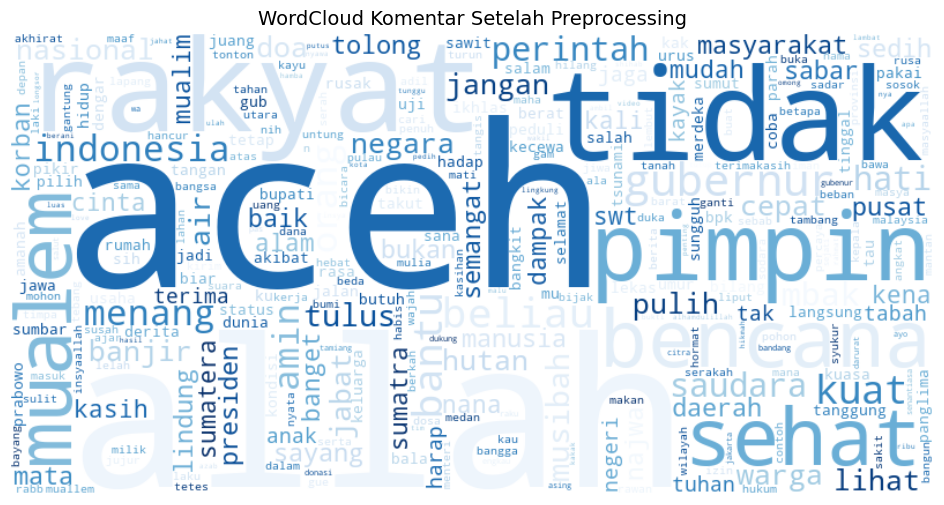

In [23]:
#@title Visualisasi WordCloud Komentar Setelah Preprocessing

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Pastikan tidak ada NaN
df_preprocessed['stemmed'] = df_preprocessed['stemmed'].fillna('')

# Gabungkan seluruh komentar
text_raw = " ".join(df_preprocessed['stemmed'].astype(str))

# Stopwords tambahan (opsional)
stopwords = set(STOPWORDS)
stopwords.update([
    'https', 'ya', 'ini', 'dan', 'yang', 'di', 'moga'
])

# Generate WordCloud
wc = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    width=800,
    height=400,
    collocations=False,
    colormap='Blues'
).generate(text_raw)

# Tampilkan WordCloud
plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Komentar Setelah Preprocessing", fontsize=14)
plt.show()

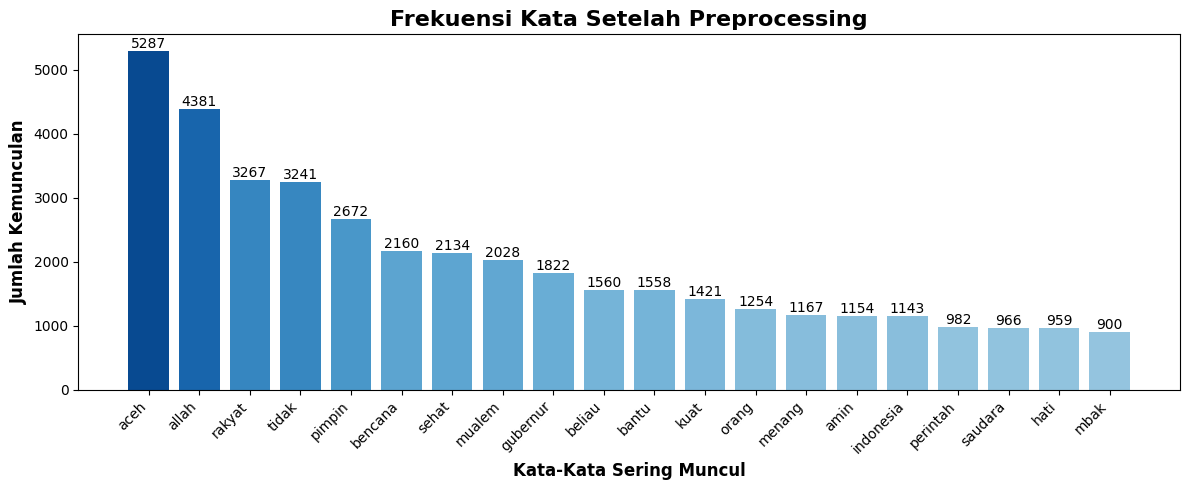

In [24]:
#@title Visualisasi Frekuensi Kata Setelah Preprocessing

import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS
import numpy as np

# Gabungkan teks hasil stemming
text = " ".join(df_preprocessed['stemmed'].astype(str))

# Stopwords tambahan (opsional, untuk visualisasi)
stopwords = set(STOPWORDS)
stopwords.update([
    'https', 'ya', 'ini', 'dan', 'yang', 'di', 'moga'
])

# Tokenisasi & filter stopwords
tokens = [word for word in text.split() if word.lower() not in stopwords]

# Hitung frekuensi
word_counts = Counter(tokens)

# Ambil Top 10 kata
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)
counts = np.array(counts)

# Normalisasi frekuensi (0–1)
norm = (counts - counts.min()) / (counts.max() - counts.min() + 1e-6)

# Warna: biru soft → biru semakin jelas
colors = plt.cm.Blues(0.4 + 0.5 * norm)

# Plot bar chart
plt.figure(figsize=(12,5))
bars = plt.bar(words, counts, color=colors)

plt.xlabel("Kata-Kata Sering Muncul", fontsize=12, fontweight='bold')
plt.ylabel("Jumlah Kemunculan", fontsize=12, fontweight='bold')
plt.title("Frekuensi Kata Setelah Preprocessing", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Tambahkan angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [22]:
#@title Simpan Hasil Preprocessing ke Excel (.xlsx)

df_preprocessed.to_excel(
    "hasil_preprocessing.xlsx",
    index=False
)

print("File berhasil disimpan ke Excel (.xlsx).")


File berhasil disimpan ke Excel (.xlsx).


# **Klasifikasi Topik dan Sentimen**

In [56]:
#@title Install Required Libraries
%pip install sentence-transformers pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [57]:
#@title Load Dataset Hasil Preprocessing

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Load dataset
path_file = "hasil_preprocessing.xlsx"
df_labeled = pd.read_excel(path_file)

# Pastikan kolom teks aman
df_labeled['stemmed'] = df_labeled['stemmed'].astype(str).fillna("")

print("Jumlah data:", len(df_labeled))

c:\Project\MESINLEARNING\svm-web-app\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jumlah data: 11332


In [58]:
#@title Shorten Text to Max 40 Words

def shorten_text(text, max_words=40):
    words = text.split()
    return " ".join(words[:max_words])

df_labeled['short_text'] = df_labeled['stemmed'].apply(shorten_text)


In [59]:
#@title Define Labels and Descriptions

labels_dictionary = {
    "Simpati & Doa":
    "Komentar yang mengekspresikan empati kepada korban bencana, doa keselamatan, kesabaran, dukungan moral, atau rasa duka atas penderitaan masyarakat",

    "Kritik Pemerintah":
    "Komentar yang mengkritik, menyalahkan, atau menuntut tanggung jawab pemerintah, pejabat, kebijakan negara, atau aparat",

    "Kerusakan Lingkungan":
    "Komentar yang menyoroti penyebab bencana akibat perusakan alam seperti sawit, tambang, hutan gundul, perusahaan rakus",

    "Dampak & Kondisi Lapangan":
    "Komentar yang menggambarkan kondisi korban, kerusakan, evakuasi, bantuan, korban jiwa, pengungsi, dan situasi lapangan"
}

label_names = list(labels_dictionary.keys())
label_texts = list(labels_dictionary.values())


In [60]:
#@title Load SentenceTransformer Embedding Model

print("Loading embedding model...")
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
print("Model ready.")


Loading embedding model...
Model ready.


In [61]:
#@title Encode Comments and Labels

print("Encoding comments...")
corpus_embeddings = model.encode(
    df_labeled['short_text'].tolist(),
    show_progress_bar=True
)

print("Encoding labels...")
label_embeddings = model.encode(label_texts)


Encoding comments...


Batches: 100%|██████████| 355/355 [01:40<00:00,  3.54it/s]


Encoding labels...


In [62]:
#@title Compute Cosine Similarity Scores

cosine_scores = util.cos_sim(corpus_embeddings, label_embeddings)


In [63]:
#@title Assign Single Label Based on Highest Cosine Similarity

def single_label(scores, label_names):
    scores = np.array(scores)

    best_idx = scores.argmax()
    best_label = label_names[best_idx]
    best_score = scores[best_idx]

    sorted_scores = np.sort(scores)[::-1]
    margin = sorted_scores[0] - sorted_scores[1]

    return best_label, best_score, margin


results = [
    single_label(cosine_scores[i], label_names)
    for i in range(len(df_labeled))
]

df_labeled['kategori'] = [r[0] for r in results]
df_labeled['confidence_score'] = [r[1] for r in results]
df_labeled['margin_score'] = [r[2] for r in results]



C:\Users\Hardika Setiyawan\AppData\Local\Temp\ipykernel_22852\3232775073.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  scores = np.array(scores)


In [64]:
#@title Tampilkan Hasil Klasifikasi Topik

df_labeled[['stemmed', 'kategori']].head(10)


,stemmed,kategori
0,moga sabar ya saudara indonesia malaysia senti...,Simpati & Doa
1,sayang anak ya lapar takut wabah sakit landa,Simpati & Doa
2,mbak najwa tolong komunikasi prabowo ya jurnal...,Dampak & Kondisi Lapangan
3,jabat menteri pegang mbak najwa ya dengar kelu...,Kritik Pemerintah
4,ibuk temuin mbak najwa ibuk ku langsung menang...,Dampak & Kondisi Lapangan
5,hebat sila rujuk meteoroloji taufan aceh mingg...,Dampak & Kondisi Lapangan
6,senyum begituya allah sehat lindung saudara ku...,Simpati & Doa
7,kuat sabar ya allah bukti kuat sabar orang tua...,Simpati & Doa
8,populasi juta sumatera utara juta sumatera bar...,Kerusakan Lingkungan
9,tuh lihat pinggir jalan tol pohon sawit sawit ...,Kerusakan Lingkungan


In [65]:
#@title Analyze Label Distribution

from collections import Counter

all_labels = []
for labels in df_labeled['kategori']:
    all_labels.extend(labels)

label_distribution = df_labeled['kategori'].value_counts()
print(label_distribution)



kategori
Simpati & Doa                3894
Dampak & Kondisi Lapangan    3065
Kerusakan Lingkungan         2899
Kritik Pemerintah            1474
Name: count, dtype: int64


In [66]:
#@title Install Required Libraries for Sentiment Analysis

from transformers import pipeline
from tqdm import tqdm
import torch

device = 0 if torch.cuda.is_available() else -1

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier",
    device=device
)

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    try:
        result = sentiment_pipeline(text[:512])[0]
        if result["label"] == "positive":
            return 1
        elif result["label"] == "negative":
            return -1
        else:
            return 0
    except:
        return 0

tqdm.pandas()
print("Melabeli sentimen dengan IndoBERT...")

df_labeled["sentimen_score"] = df_labeled["stemmed"].progress_apply(get_sentiment)

print("Labeling sentimen selesai.")


Device set to use cpu


Melabeli sentimen dengan IndoBERT...


100%|██████████| 11332/11332 [08:51<00:00, 21.33it/s]

Labeling sentimen selesai.


In [67]:
#@title Refine Sentiment for "Simpati & Doa" Category

PRAYER_WORDS = [
    'semoga','aamiin','amin','allah','tuhan','sabar','tabah','ikhlas',
    'semangat','lindung','husnul','khotimah','surga','doa','turut',
    'duka','cita','sayang','sedih','doakan','cinta','kuat',
    'alhamdulillah','saudara','sehat','pulih','korban','selamat',
    'rahmat','rezeki','donasi','menangis','kesedihan','kesehatan',
    'limpahkan','baik','hati'
]

def fix_simpati_sentiment(row):
    if row["kategori"] != "Simpati & Doa":
        return row["sentimen_score"]

    if row["sentimen_score"] == 1:
        return 1

    text = str(row["stemmed"]).lower()
    if any(word in text for word in PRAYER_WORDS):
        return 1

    return row["sentimen_score"]

# Statistik sebelum
before_neg = df_labeled[
    (df_labeled["kategori"] == "Simpati & Doa") &
    (df_labeled["sentimen_score"] == -1)
].shape[0]

# Terapkan refinement
df_labeled["sentimen_score"] = df_labeled.apply(
    fix_simpati_sentiment, axis=1
)

# Statistik sesudah
after_neg = df_labeled[
    (df_labeled["kategori"] == "Simpati & Doa") &
    (df_labeled["sentimen_score"] == -1)
].shape[0]

print(f"Negatif sebelum fix : {before_neg}")
print(f"Negatif sesudah fix : {after_neg}")
print(f"Total koreksi       : {before_neg - after_neg}")


Negatif sebelum fix : 813
Negatif sesudah fix : 164
Total koreksi       : 649


In [ ]:
#@title Prepare Sample for Manual Annotation

SAMPLE_SIZE = 400
df_sample_manual = df_labeled.sample(
    n=SAMPLE_SIZE,
    random_state=42
)

# Simpan untuk anotasi manual
df_sample_manual[
    ["stemmed", "kategori", "sentimen_score"]
].to_excel(
    "sample_manual_sentiment.xlsx",
    index=False
)

print("File sample_manual_sentiment.xlsx siap untuk anotasi manual.")


File sample_manual_sentiment.xlsx siap untuk anotasi manual.


In [69]:
#@title Calculate Cohen's Kappa for Sentiment Labels

from sklearn.metrics import cohen_kappa_score
import pandas as pd

df_manual = pd.read_excel("sample_manual_sentiment.xlsx")

kappa = cohen_kappa_score(
    df_manual["sentimen_manual"],
    df_manual["sentimen_score"]
)

print("Cohen’s Kappa (Sentimen):", round(kappa, 3))


Cohen’s Kappa (Sentimen): 0.798


In [70]:
#@title Simpan Dataset Final Sentimen

sentiment_map = {
    -1: "Negatif",
     0: "Netral",
     1: "Positif"
}

df_labeled["sentimen"] = df_labeled["sentimen_score"].map(sentiment_map)

# Pilih kolom penting saja
columns_to_save = [
    "comment",
    "stemmed",
    "kategori",
    "sentimen"
]

df_final = df_labeled[columns_to_save].copy()

# Simpan ke Excel
df_final.to_excel(
    "hasil_labeling.xlsx",
    index=False
)

print("Dataset final sentimen berhasil disimpan (kolom terpilih).")



Dataset final sentimen berhasil disimpan (kolom terpilih).


# **Visualisasi Hasil Labeling**

In [71]:
#@title Tahap Import Library & Persiapan Data
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Load Data
path_file = "hasil_labeling.xlsx"
df_vis = pd.read_excel(path_file)

# --- PERBAIKAN DI SINI ---
# Pastikan kita mapping dari SKOR ANGKA, bukan dari teks yang sudah jadi
sentimen_map = {1: 'Positif', 0: 'Netral', -1: 'Negatif'}

# Cek kolom mana yang tersedia untuk mapping
if 'sentimen_score' in df_vis.columns:
    df_vis['label_teks'] = df_vis['sentimen_score'].map(sentimen_map)
else:
    # Jika score tidak ada, kita asumsikan kolom 'sentimen' sudah berisi teks yang benar
    df_vis['label_teks'] = df_vis['sentimen']

# Konfigurasi Warna
colors_sentimen_dict = {
    'Positif': '#2ecc71', # Hijau
    'Netral': '#95a5a6',  # Abu
    'Negatif': '#e74c3c'  # Merah
}

# Warna Topik Pastel
colors_topik = sns.color_palette('pastel')[0:4]

print("Data siap divisualisasikan!")
print(f"Sample label: {df_vis['label_teks'].head(3).values}")

Note: you may need to restart the kernel to use updated packages.
Data siap divisualisasikan!
Sample label: ['Positif' 'Positif' 'Netral']


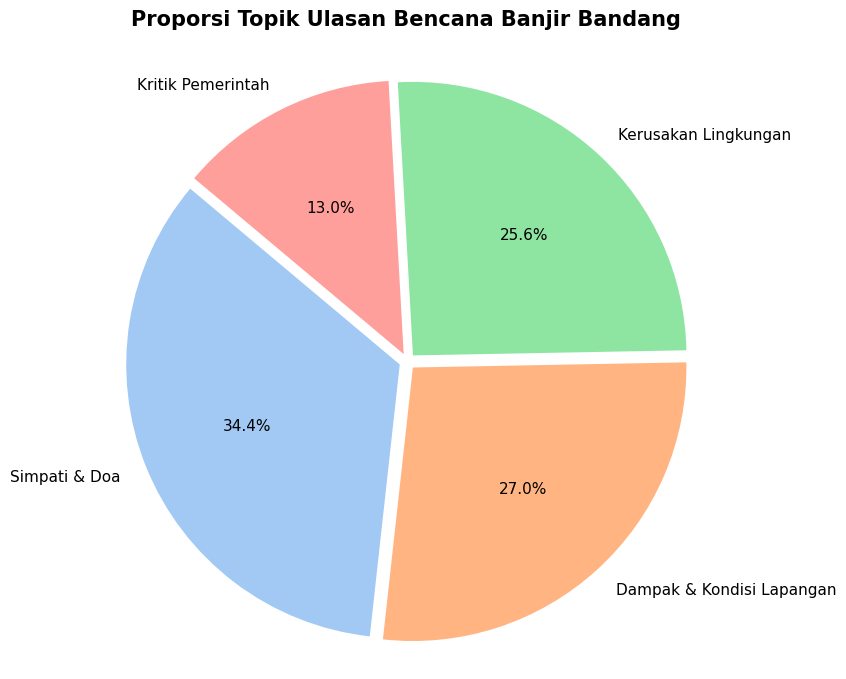

In [72]:
#@title Tahap Membuat Pie Chart Distribusi Topik Global
plt.figure(figsize=(10, 8))

# Hitung jumlah data per kategori
topik_counts = df_vis['kategori'].value_counts()

# Plotting
plt.pie(topik_counts,
        labels=topik_counts.index,
        autopct='%1.1f%%',       # Menampilkan persentase desimal
        startangle=140,          # Memutar posisi awal agar estetik
        colors=colors_topik,     # Warna pastel
        explode=[0.03]*len(topik_counts), # Memberi jarak sedikit antar irisan
        textprops={'fontsize': 11}) # Ukuran font teks

plt.title('Proporsi Topik Ulasan Bencana Banjir Bandang', fontsize=15, fontweight='bold', pad=20)
plt.axis('equal') # Memastikan lingkaran berbentuk bulat sempurna

plt.show()

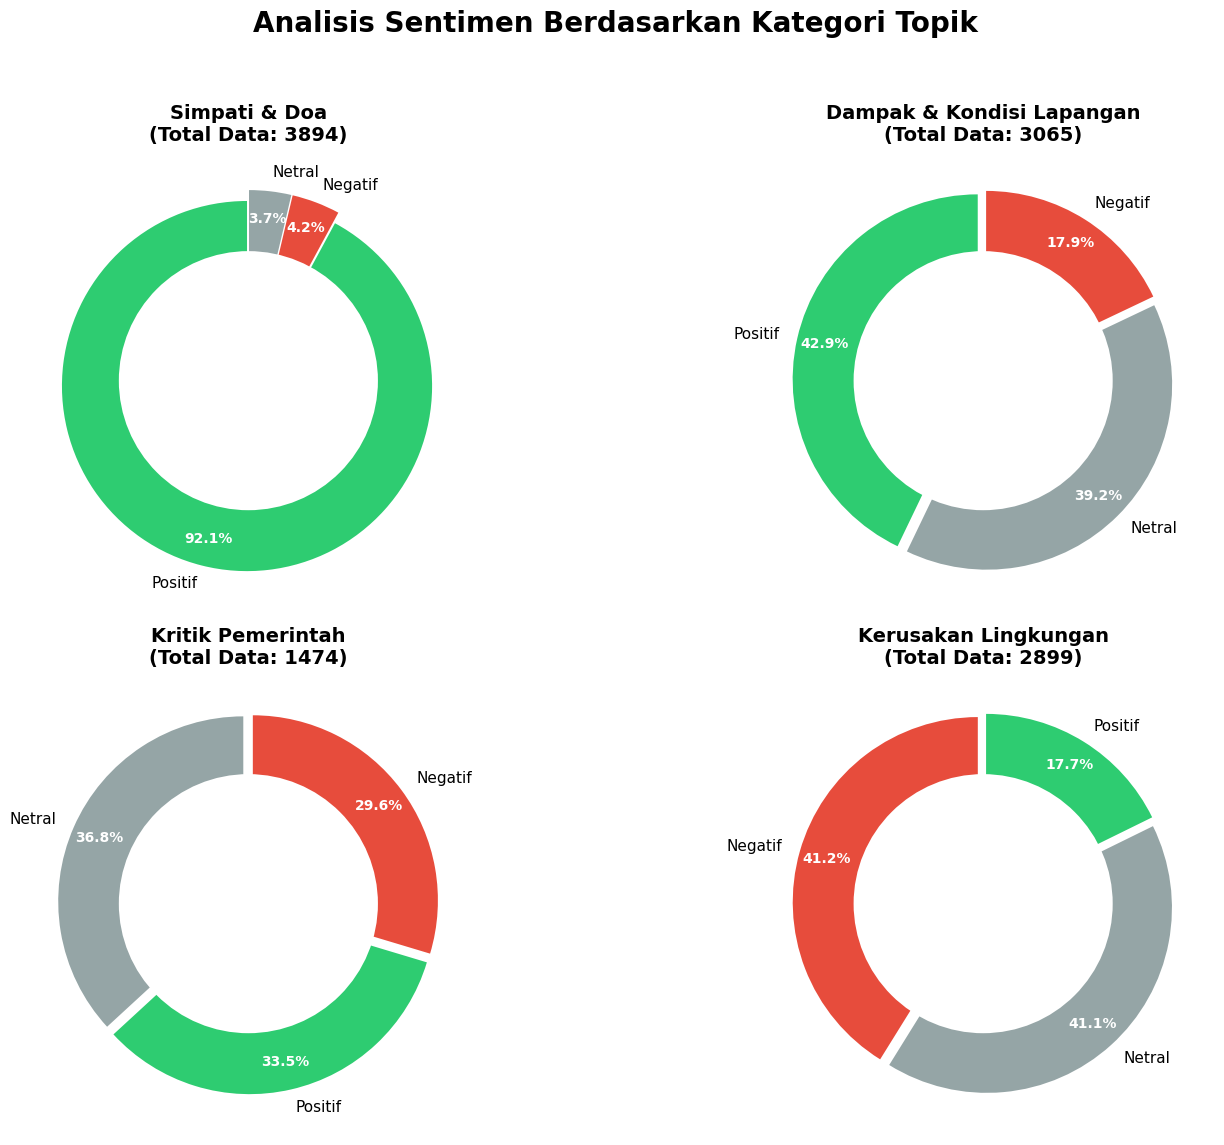

In [73]:
#@title Tahap Membuat Pie Chart Sentimen per Topik
import matplotlib.pyplot as plt

# Pastikan library dan data sudah siap (menggunakan df_vis dan colors_sentimen_dict dari tahap sebelumnya)

# Ambil daftar topik unik
topics_list = df_vis['kategori'].unique()
jumlah_topik = len(topics_list)

# Siapkan Canvas (Grid 2x2)
# Jika topiknya lebih dari 4, perlu ubah ukuran grid ini (misal 2,3)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisis Sentimen Berdasarkan Kategori Topik', fontsize=20, fontweight='bold', y=0.98)

# Ratakan axes agar mudah di-loop (dari array 2D jadi 1D)
axes_flat = axes.flatten()

# Loop untuk membuat grafik
for i, ax in enumerate(axes_flat):

    # Cek apakah indeks saat ini masih dalam jangkauan jumlah topik
    if i < jumlah_topik:
        topic = topics_list[i]

        # 1. Filter data khusus topik ini
        data_topic = df_vis[df_vis['kategori'] == topic]
        sentimen_counts = data_topic['label_teks'].value_counts()

        # 2. Atur Warna (Mapping manual agar konsisten)
        chart_labels = sentimen_counts.index
        # List comprehension untuk mengambil warna sesuai label
        chart_colors = [colors_sentimen_dict[label] for label in chart_labels]

        # 3. Plotting Pie Chart
        wedges, texts, autotexts = ax.pie(sentimen_counts,
                                          labels=chart_labels,
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=chart_colors,
                                          pctdistance=0.85,
                                          explode=[0.03]*len(sentimen_counts)) # Sedikit jarak antar irisan

        # Kosmetik Font
        for text in texts:
            text.set_fontsize(11)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)

        # Judul per Grafik
        ax.set_title(f"{topic}\n(Total Data: {len(data_topic)})", fontsize=14, fontweight='bold')

        # Lingkaran tengah (Donut Chart Style)
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        ax.add_artist(centre_circle)

    else:
        # Jika kotak lebih banyak dari topik (misal ada 4 kotak tapi cuma 3 topik)
        # Sembunyikan axis/kotak yang sisa agar tidak ada kotak kosong jelek
        ax.axis('off')

# Rapikan layout agar judul tidak tertabrak
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Tampilkan langsung di Colab
plt.show()

# **Kata Kunci Setiap Label**

In [74]:
#@title Install Library & Load Data
%pip install Sastrawi openpyxl -q

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# --- KONFIGURASI FILE ---
path_file_final = "hasil_labeling.xlsx"
path_output_excel = "hasil_analisis_keywords.xlsx"

# Load Data
df_keyword = pd.read_excel(path_file_final)
print(f"Berhasil memuat data: {len(df_keyword)} baris.")

# Pastikan kolom teks aman
df_keyword['stemmed'] = df_keyword['stemmed'].fillna('')


Note: you may need to restart the kernel to use updated packages.
Berhasil memuat data: 11332 baris.


In [75]:
#@title Setup Stopwords
factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()

custom_stopwords = [
    'dan','yang','di','ini','itu','saya','aku','yg','gak','nya',
    'kalo','aja','sih','udah','ada','bisa','lagi','mau','sama',
    'tak','kok','biar','deh'
]
stopword_list.extend(custom_stopwords)


In [76]:
#@title Fungsi Ekstraksi Keyword
def get_top_keywords(data, column_text='stemmed', top_n=20):
    if data.empty:
        return "-"

    vec = CountVectorizer(
        stop_words=stopword_list,
        max_features=1000,
        token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
    )

    try:
        bag_of_words = vec.fit_transform(data[column_text])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, int(sum_words[0, idx]))
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        top_words = [word for word, freq in words_freq[:top_n]]
        return ", ".join(top_words)
    except ValueError:
        return "-"


In [77]:
#@title Gabungkan Keyword Topik & Sentimen ke satu table

final_keyword_data = []

# --- Keyword per TOPIK ---
for cat in sorted(df_keyword['kategori'].unique()):
    subset = df_keyword[df_keyword['kategori'] == cat]
    final_keyword_data.append({
        "Jenis": "Topik",
        "Label": cat,
        "Jumlah Data": len(subset),
        "Kata Kunci Dominan": get_top_keywords(subset)
    })

# --- Keyword per SENTIMEN ---
for sent in ['Positif', 'Netral', 'Negatif']:
    subset = df_keyword[df_keyword['sentimen'] == sent]
    final_keyword_data.append({
        "Jenis": "Sentimen",
        "Label": sent,
        "Jumlah Data": len(subset),
        "Kata Kunci Dominan": get_top_keywords(subset)
    })

df_final_keywords = pd.DataFrame(final_keyword_data)

print("=== HASIL AKHIR KEYWORD (TOPIK + SENTIMEN) ===")
display(df_final_keywords)


=== HASIL AKHIR KEYWORD (TOPIK + SENTIMEN) ===


,Jenis,Label,Jumlah Data,Kata Kunci Dominan
0,Topik,Dampak & Kondisi Lapangan,3065,"aceh, allah, moga, rakyat, pimpin, indonesia, ..."
1,Topik,Kerusakan Lingkungan,2899,"bencana, aceh, rakyat, hutan, moga, allah, nas..."
2,Topik,Kritik Pemerintah,1474,"gubernur, aceh, rakyat, pimpin, presiden, alla..."
3,Topik,Simpati & Doa,3894,"allah, aceh, moga, rakyat, pimpin, sehat, mual..."
4,Sentimen,Positif,5909,"allah, aceh, moga, rakyat, pimpin, sehat, mual..."
5,Sentimen,Netral,3079,"aceh, bencana, bantu, gubernur, moga, rakyat, ..."
6,Sentimen,Negatif,2344,"bencana, aceh, rakyat, orang, perintah, allah,..."


In [78]:
#@title Simpan ke excel
df_final_keywords.to_excel(
    path_output_excel,
    index=False
)

print(f"Hasil analisis keyword disimpan di: {path_output_excel}")


Hasil analisis keyword disimpan di: hasil_analisis_keywords.xlsx


# **Wordcloud dan Frekuensi Kata Setiap Topik Ulasan**

In [79]:
#@title Install dan Import Library WordCloud
%pip install wordcloud --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter


print("Library WordCloud berhasil dimuat.")


Note: you may need to restart the kernel to use updated packages.
Library WordCloud berhasil dimuat.


In [80]:
#@title Fungsi Visualisasi WordCloud dan Frekuensi Kata per Topik

# Load dataset dari Google Drive
file_path = 'hasil_labeling.xlsx'
df_vis = pd.read_excel(file_path)

def plot_wordcloud_and_barchart(df, label_name, colormap='Blues'):
    # Filter data berdasarkan label
    df_vis = df[df['kategori'] == label_name]

    if df_vis.empty:
        print(f"[WARNING] Tidak ada data kategori: {label_name}")
        return

    # Gabungkan semua kata dari kolom stemmed
    all_words = []
    for text in df_vis['stemmed']:
        if isinstance(text, str):
            all_words.extend(text.split())

    if len(all_words) == 0:
        print(f"[WARNING] Tidak ada kata valid kategori: {label_name}")
        return

    # Stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(['https', 'ya', 'moga'])

    # Tambahan stopwords khusus untuk label "komentar biasa"
    if label_name.lower() == "Simpati & Doa":
        stopwords.update(['aceh', 'gubernur'])

    # Filter stopwords sebelum hitung frekuensi
    all_words_filtered = [w for w in all_words if w.lower() not in stopwords]

    # Hitung frekuensi kata
    word_freq = Counter(all_words_filtered)

    # Top 20 kata
    top_words = word_freq.most_common(20)

    # WordCloud
    wc = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        colormap=colormap,
        prefer_horizontal=1
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud Topik: {label_name}", fontsize=16)
    plt.show()

    # Bar Chart Frekuensi - Warna Biru Dinamis
    words, counts = zip(*top_words)
    plt.figure(figsize=(12,6))

    # Normalisasi frekuensi ke 0-1 untuk mapping warna
    counts_array = np.array(counts)
    norm = (counts_array - counts_array.min()) / (counts_array.max() - counts_array.min() + 1e-5)  # +1e-5 untuk hindari div0
    # Mapping ke rentang 0.4-0.8 supaya tetap soft
    colors = plt.cm.Blues(0.4 + 0.4 * norm)

    bars = plt.bar(words, counts, color=colors)

    # Tambahkan angka di atas bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Frekuensi")
    plt.title(f"Top 20 Kata Teratas - {label_name}", fontsize=16)
    plt.show()


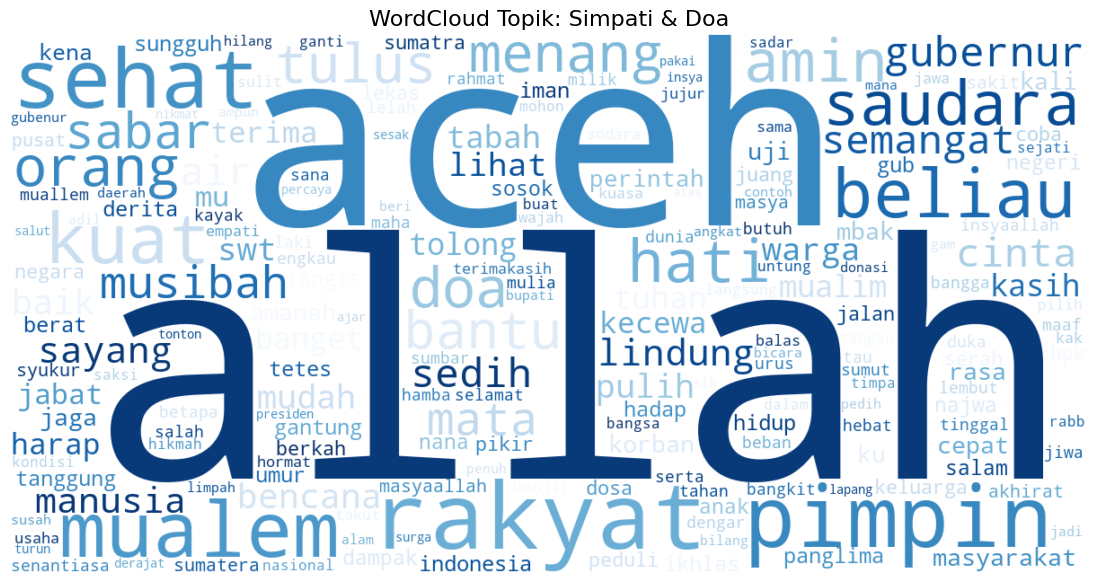

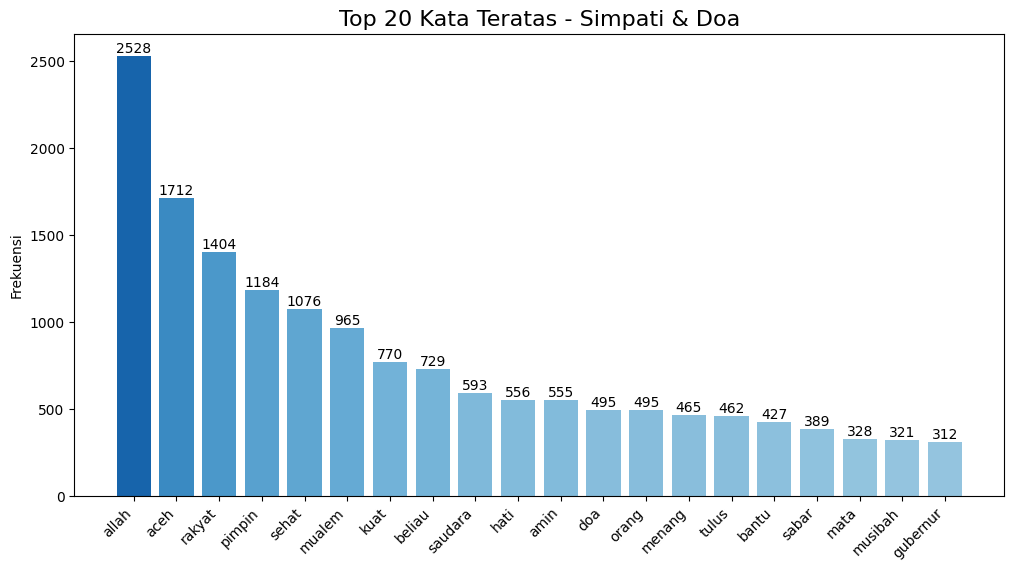

In [86]:
#@title WordCloud Topik: Simpati & Doa

plot_wordcloud_and_barchart(
    df_vis,
    label_name="Simpati & Doa",
    colormap="Blues"
)

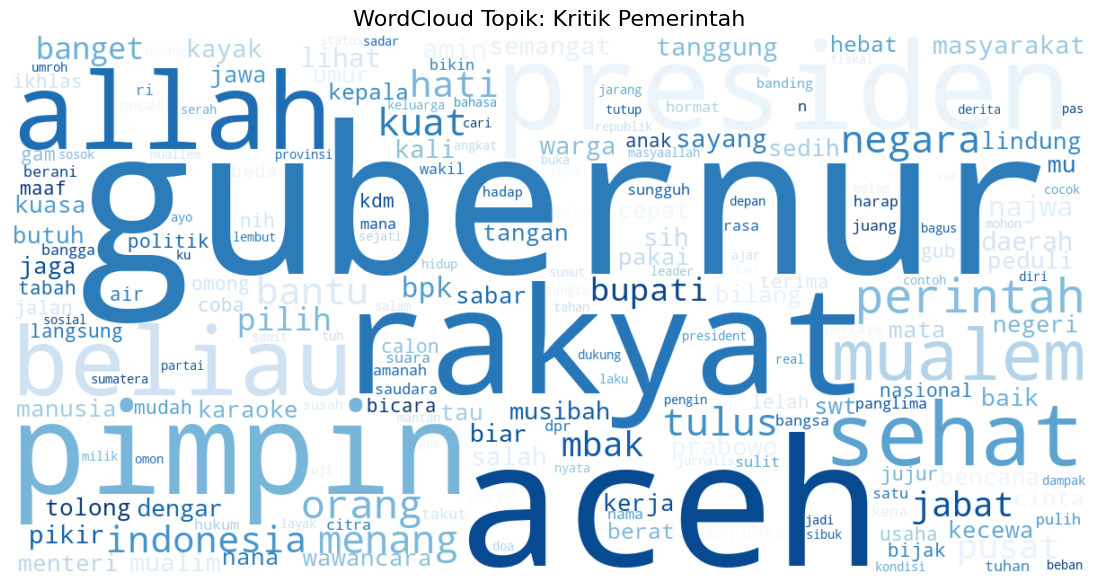

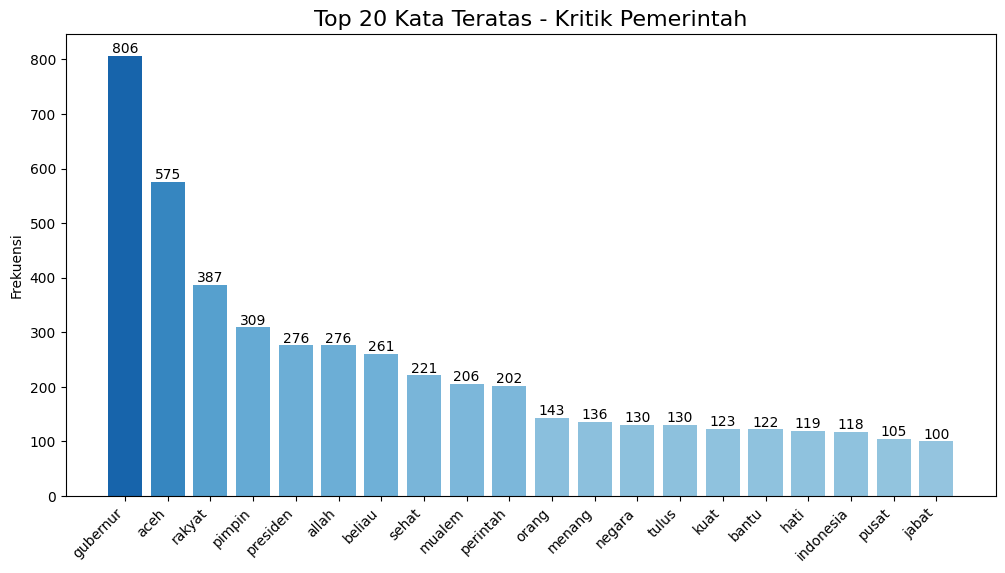

In [87]:
#@title WordCloud Topik: Kritik Pemerintah

plot_wordcloud_and_barchart(
    df_vis,
    label_name="Kritik Pemerintah",
    colormap="Blues"
)


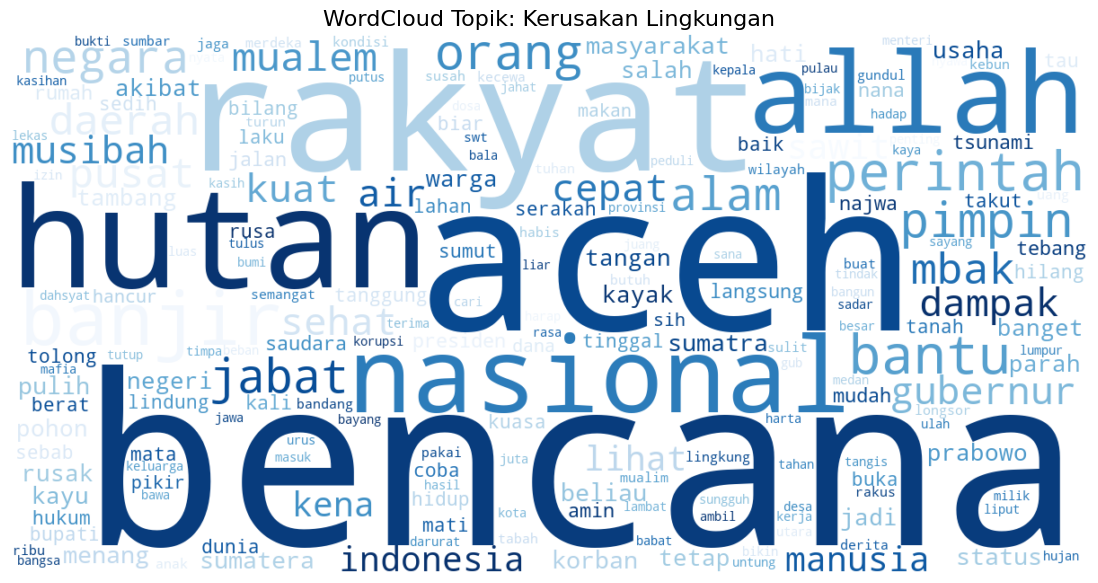

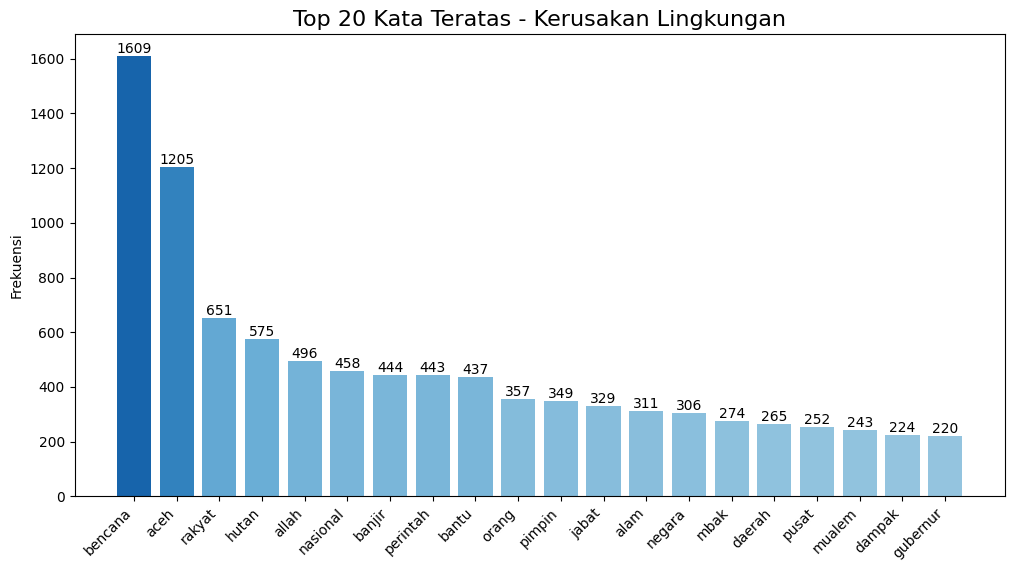

In [88]:
#@title WordCloud Topik: Kerusakan Lingkungan

plot_wordcloud_and_barchart(
    df_vis,
    label_name="Kerusakan Lingkungan",
    colormap="Blues"
)


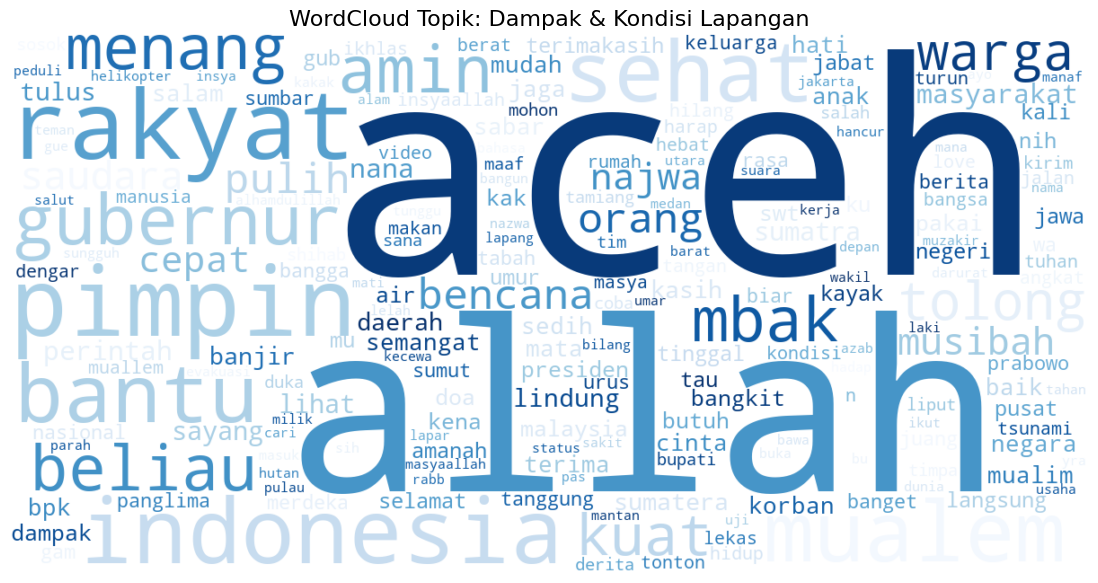

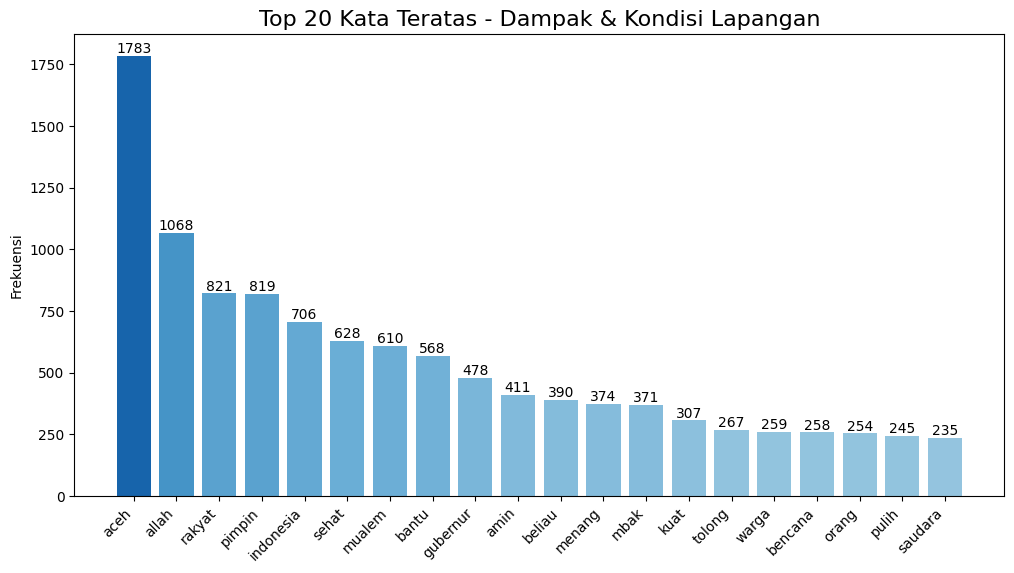

In [90]:
#@title WordCloud Topik: Dampak & Kondisi Lapangan

plot_wordcloud_and_barchart(
    df_vis,
    label_name="Dampak & Kondisi Lapangan",
    colormap="Blues"
)


# **Pemodelan Support Vector Machine**

In [93]:
#@title Memuat Dataset Siap Modeling (Hasil Preprocessing & Labeling)

import pandas as pd
import numpy as np

# Load dataset
path = "hasil_labeling.xlsx"
df_model = pd.read_excel(path)

# Pastikan kolom teks aman
df_model['stemmed'] = df_model['stemmed'].astype(str).fillna("")

print("Jumlah data:", df_model.shape)
df_model.head()


Jumlah data: (11332, 4)


,comment,stemmed,kategori,sentimen
0,Moga bersabar ya saudaraku dri Indonesia kami ...,moga sabar ya saudara indonesia malaysia senti...,Simpati & Doa,Positif
1,Sayangi anak2 kami y kelaparan dan takut wabah...,sayang anak ya lapar takut wabah sakit landa,Simpati & Doa,Positif
2,Mbak Najwa tolong komunikasi sama pak prabowo ...,mbak najwa tolong komunikasi prabowo ya jurnal...,Dampak & Kondisi Lapangan,Netral
3,2029 jabatan menteri apa yang pantas di pegan...,jabat menteri pegang mbak najwa ya dengar kelu...,Kritik Pemerintah,Negatif
4,Ibuk yang pertama di temuin mbak najwa mirip i...,ibuk temuin mbak najwa ibuk ku langsung menang...,Dampak & Kondisi Lapangan,Positif


In [96]:
#@title Import Library Modeling

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# **Topik**

In [98]:
#@title Split Data Latih & Data Uji

from sklearn.model_selection import train_test_split

X = df_model['stemmed']
y = df_model['kategori']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])




Train size: 10198
Test size : 1134


In [99]:
#@title TF-IDF Vectorization for Topic Classification

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_topic = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf_topic = tfidf_topic.fit_transform(X_train)
X_test_tfidf_topic  = tfidf_topic.transform(X_test)

print("TF-IDF TOPIK Train:", X_train_tfidf_topic.shape)
print("TF-IDF TOPIK Test :", X_test_tfidf_topic.shape)



TF-IDF TOPIK Train: (10198, 22865)
TF-IDF TOPIK Test : (1134, 22865)


In [100]:
#@title Feature Selection with Chi-Square for Topic Classification

from sklearn.feature_selection import SelectKBest, chi2

chi2_selector_topic = SelectKBest(
    score_func=chi2,
    k=8000
)

X_train_chi2_topic = chi2_selector_topic.fit_transform(
    X_train_tfidf_topic, y_train
)
X_test_chi2_topic = chi2_selector_topic.transform(
    X_test_tfidf_topic
)

print("Setelah Chi-Square:", X_train_chi2_topic.shape)


Setelah Chi-Square: (10198, 8000)


In [101]:
#@title Train LinearSVC for Topic Classification

from sklearn.svm import LinearSVC

svm_topic = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42
)

svm_topic.fit(X_train_chi2_topic, y_train)

y_pred_topic = svm_topic.predict(X_test_chi2_topic)



In [102]:
#@title Evaluate Topic Classification Model

from sklearn.metrics import classification_report, confusion_matrix

print("=== Classification Report (TOPIK) ===")
print(classification_report(y_test, y_pred_topic, digits=4))


=== Classification Report (TOPIK) ===
                           precision    recall  f1-score   support

Dampak & Kondisi Lapangan     0.6958    0.5961    0.6421       307
     Kerusakan Lingkungan     0.7558    0.7897    0.7723       290
        Kritik Pemerintah     0.6185    0.7279    0.6687       147
            Simpati & Doa     0.8000    0.8103    0.8051       390

                 accuracy                         0.7363      1134
                macro avg     0.7175    0.7310    0.7221      1134
             weighted avg     0.7370    0.7363    0.7349      1134



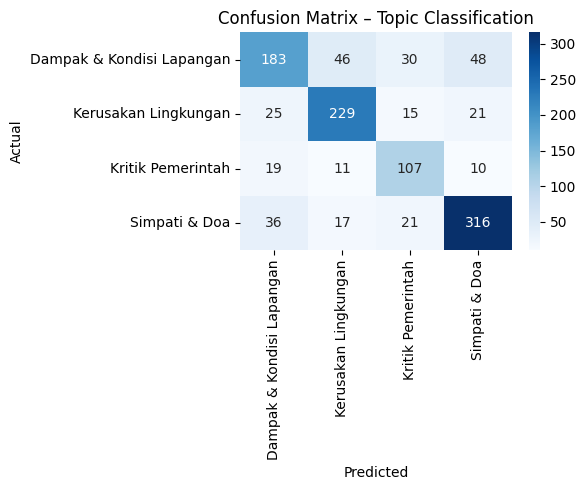

In [103]:
#@title Confusion Matrix for Topic Classification

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_topic)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=svm_topic.classes_,
    yticklabels=svm_topic.classes_
)

plt.title("Confusion Matrix – Topic Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [104]:
#@title Cross-Validation Macro-F1 Score for Topic Classification

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipeline_topic = Pipeline([
    ('tfidf', tfidf_topic),
    ('chi2', chi2_selector_topic),
    ('svm', LinearSVC(class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

macro_f1_scores = cross_val_score(
    pipeline_topic,
    X,
    y,
    cv=cv,
    scoring='f1_macro'
)

print("Macro-F1 per fold:", macro_f1_scores)
print("Mean Macro-F1     :", macro_f1_scores.mean())


Macro-F1 per fold: [0.71473119 0.72796741 0.72886651 0.7310388  0.72048722]
Mean Macro-F1     : 0.7246182251543078


# **Sentimen**

In [105]:
#@title Split Data Latih & Data Uji untuk Sentiment Analysis

from sklearn.model_selection import train_test_split

X = df_model['stemmed']
y = df_model['sentimen']   # Positif / Netral / Negatif

print("Distribusi Sentimen:")
print(y.value_counts())

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train_s.shape[0])
print("Test size :", X_test_s.shape[0])


Distribusi Sentimen:
sentimen
Positif    5909
Netral     3079
Negatif    2344
Name: count, dtype: int64
Train size: 9065
Test size : 2267


In [106]:
#@title TF-IDF Vectorization for Sentiment Analysis

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_sentiment = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf_s = tfidf_sentiment.fit_transform(X_train_s)
X_test_tfidf_s  = tfidf_sentiment.transform(X_test_s)

print("TF-IDF SENTIMEN Train:", X_train_tfidf_s.shape)
print("TF-IDF SENTIMEN Test :", X_test_tfidf_s.shape)


TF-IDF SENTIMEN Train: (9065, 21619)
TF-IDF SENTIMEN Test : (2267, 21619)


In [107]:
#@title Feature Selection with Chi-Square for Sentiment Analysis

from sklearn.feature_selection import SelectKBest, chi2

chi2_selector_sent = SelectKBest(
    score_func=chi2,
    k=8000
)

X_train_chi2_s = chi2_selector_sent.fit_transform(
    X_train_tfidf_s, y_train_s
)
X_test_chi2_s = chi2_selector_sent.transform(
    X_test_tfidf_s
)

print("Setelah Chi-Square SENTIMEN:", X_train_chi2_s.shape)


Setelah Chi-Square SENTIMEN: (9065, 8000)


In [108]:
#@title Train LinearSVC for Sentiment Analysis

from sklearn.svm import LinearSVC

svm_sentiment = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42
)

svm_sentiment.fit(X_train_chi2_s, y_train_s)

y_pred_sentiment = svm_sentiment.predict(X_test_chi2_s)


In [109]:
#@title Evaluate Sentiment Analysis Model

from sklearn.metrics import classification_report, confusion_matrix

print("=== Classification Report (SENTIMEN) ===")
print(classification_report(y_test_s, y_pred_sentiment, digits=4))


=== Classification Report (SENTIMEN) ===
              precision    recall  f1-score   support

     Negatif     0.6566    0.6930    0.6743       469
      Netral     0.7076    0.7110    0.7093       616
     Positif     0.8630    0.8418    0.8522      1182

    accuracy                         0.7755      2267
   macro avg     0.7424    0.7486    0.7453      2267
weighted avg     0.7780    0.7755    0.7766      2267



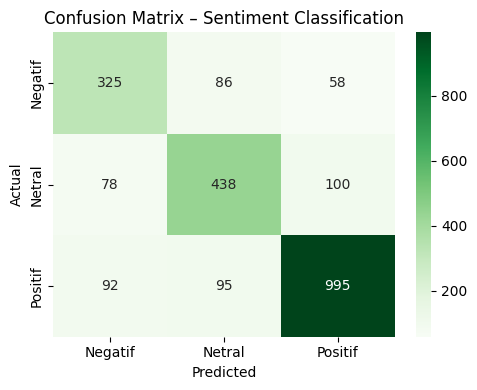

In [110]:
#@title Confusion Matrix for Sentiment Analysis

import matplotlib.pyplot as plt
import seaborn as sns

cm_s = confusion_matrix(y_test_s, y_pred_sentiment)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_s,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=svm_sentiment.classes_,
    yticklabels=svm_sentiment.classes_
)

plt.title("Confusion Matrix – Sentiment Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [111]:
#@title Cross-Validation Macro-F1 Score for Sentiment Analysis

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipeline_sentiment = Pipeline([
    ('tfidf', tfidf_sentiment),
    ('chi2', chi2_selector_sent),
    ('svm', LinearSVC(class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

macro_f1_scores_s = cross_val_score(
    pipeline_sentiment,
    X,
    y,
    cv=cv,
    scoring='f1_macro'
)

print("Macro-F1 per fold (Sentimen):", macro_f1_scores_s)
print("Mean Macro-F1 (Sentimen)     :", macro_f1_scores_s.mean())


Macro-F1 per fold (Sentimen): [0.74457454 0.74003922 0.72519524 0.72955094 0.72426609]
Mean Macro-F1 (Sentimen)     : 0.7327252083377559


# **Penyimpanan Model**

In [112]:
#@title Save Topic Classification Model

import joblib
import os

BASE_DIR = r"C:\Project\MESINLEARNING\svm-web-app\backend\models"

topic_dir = os.path.join(BASE_DIR, "topic")
os.makedirs(topic_dir, exist_ok=True)

joblib.dump(tfidf_topic, os.path.join(topic_dir, "tfidf_topic.joblib"))
joblib.dump(chi2_selector_topic, os.path.join(topic_dir, "chi2_topic.joblib"))
joblib.dump(svm_topic, os.path.join(topic_dir, "svm_topic.joblib"))

print("Model TOPIK berhasil disimpan.")


Model TOPIK berhasil disimpan.


In [ ]:
#@title Save Sentiment Analysis Model

sentiment_dir = os.path.join(BASE_DIR, "sentiment")
os.makedirs(sentiment_dir, exist_ok=True)

joblib.dump(tfidf_sentiment, os.path.join(sentiment_dir, "tfidf_sentiment.joblib"))
joblib.dump(chi2_selector_sent, os.path.join(sentiment_dir, "chi2_sentiment.joblib"))
joblib.dump(svm_sentiment, os.path.join(sentiment_dir, "svm_sentiment.joblib"))

print("Model SENTIMEN berhasil disimpan.")


Model SENTIMEN berhasil disimpan.
